In [1]:

# !pip uninstall -y torch torchvision torchaudio transformers accelerate \
#     scikit-learn pandas numpy tqdm optuna jax jaxlib opencv-python opencv-python-headless opencv-contrib-python -q

# # Install EXACT Colab ML ecosystem versions
# !pip install -q torch==2.8.0 torchvision==0.23.0 torchaudio==2.8.0 --index-url https://download.pytorch.org/whl/cu126
# !pip install -q transformers==4.48.0 accelerate==1.4.0 scikit-learn==1.6.0 pandas==2.2.2 numpy==2.1.0 tqdm==4.67.1 optuna==4.2.0

# import os; os.kill(os.getpid(), 9)


In [2]:
import os, gc, math, random, json, re
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.utils.prune as prune
from torch.utils.data import Dataset, DataLoader

from transformers import (AutoTokenizer, AutoModelForSequenceClassification,
                          get_linear_schedule_with_warmup)
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, accuracy_score, classification_report
from sklearn.utils.class_weight import compute_class_weight

from tqdm.auto import tqdm

SEED = 42
def set_seed(seed=SEED):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
set_seed()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda



## 1) Data: load & clean

- Point `DATA_PATH` to your **Excel/CSV**.  
- The script expects at least: `idx` (group/patient/id), `text` (clinical note), `label` (disease string).  
- If names differ, use `COLUMN_MAP` below.


###Hyperparameters

In [3]:

DATA_PATH = "/content/clinical_notes_single_label.csv"
SAVE_DIR = Path("/content/fed_clinicalbert_outputs")
SAVE_DIR.mkdir(parents=True, exist_ok=True)

COLUMN_MAP = {
    "idx": "idx",
    "text": "full_note",        # primary text source
    "label": "disease_label"    # ground-truth single label (13 including "no_disease")
}

EXPECTED_NUM_LABELS = 13

# Federated Learning Configuration
NUM_CLIENTS = 5
FEDERATED_ROUNDS = 10
LOCAL_EPOCHS = 10
BATCH_SIZE = 16
MAX_LEN = 256
DIRICHLET_ALPHA = 0.3  # Uneven distribution (lower = more skewed)

# Model Configuration
MODEL_NAME = "emilyalsentzer/Bio_ClinicalBERT"
TRAINABLE_LAYERS = 4  # First 4 encoder layers

# Training Configuration
LEARNING_RATE = 2e-5
WEIGHT_DECAY = 0.01
USE_CLASS_WEIGHTS = True
USE_FOCAL_LOSS = False
EARLY_STOP_PATIENCE = 3

# Pruning & Quantization Configuration
ENABLE_PRUNING = True
PRUNING_START_ROUND = 8
PRUNING_AMOUNT = 0.3  # 30% sparsity

In [4]:
from pathlib import Path
import pandas as pd, re
from collections import Counter

def robust_read_csv(path):
    p = Path(path)
    if p.suffix.lower() in [".xlsx", ".xls"]:
        return pd.read_excel(p, engine="openpyxl")

    try:
        return pd.read_csv(p, encoding="utf-8-sig")
    except Exception:
        pass

    try:
        return pd.read_csv(p, engine="python", sep=None, quoting=3, on_bad_lines="skip")
    except Exception as e:
        print("Primary read failed, trying fallback:", e)

    # fallback repair
    tmp = Path("/content/_repaired.csv")
    fixed = []
    with open(p, "r", errors="ignore") as f:
        for line in f:
            fixed.append(line.replace("\x00", " ").rstrip("\n"))
    with open(tmp, "w", encoding="utf-8") as g:
        g.write("\n".join(fixed))
    return pd.read_csv(tmp, engine="python", sep=None, quoting=3, on_bad_lines="skip")

def normalize_text(s: str) -> str:
    if not isinstance(s, str): return ""
    s = s.replace("\r\n", "\n").replace("\r", "\n")
    s = re.sub(r"\s+", " ", s).strip()
    return s

def clean_dataframe(df: pd.DataFrame, colmap: dict) -> pd.DataFrame:

    idx_col   = colmap["idx"]
    text_col  = colmap["text"]
    label_col = colmap["label"]

    # Helpful assertions so typos fail fast
    assert idx_col   in df.columns,   f"Missing column: {idx_col}"
    assert text_col  in df.columns,   f"Missing column: {text_col}"
    assert label_col in df.columns,   f"Missing column: {label_col}"

    out = df[[idx_col, text_col, label_col]].copy()
    out.columns = ["idx", "text", "label"]

    # cleaning
    out["text"]  = out["text"].apply(normalize_text)
    out["label"] = out["label"].astype(str).str.strip()

    # Drop empty
    out = out[(out["text"].str.len() > 3) & (out["label"].str.len() > 0)]

    # patient id & exact note
    before = len(out)
    out = out.drop_duplicates(subset=["idx", "text"])
    print(f"Removed duplicates: {before - len(out)}")

    # Final NaNs + types
    out = out.dropna(subset=["idx", "text", "label"])
    out["idx"] = out["idx"].astype(str)

    return out

# ---- Run cleaning ----

# Load and clean data

print("\n📂 LOADING AND CLEANING DATA\n")


df_raw = robust_read_csv(DATA_PATH)
print("Raw shape:", df_raw.shape)
df = clean_dataframe(df_raw, COLUMN_MAP)
print("Clean shape:", df.shape)
print("Sample labels:", Counter(df['label']).most_common(5))


📂 LOADING AND CLEANING DATA

Raw shape: (30000, 10)
Removed duplicates: 0
Clean shape: (30000, 3)
Sample labels: [('cancer', 6899), ('no_disease', 4231), ('hypertension', 3204), ('diabetes mellitus', 2944), ('heart disease', 2730)]


In [5]:

# Encode labels
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df["label_id"] = le.fit_transform(df["label"].astype(str))

num_labels = len(le.classes_)
print("Num labels discovered:", num_labels, le.classes_[:10], "...")

if EXPECTED_NUM_LABELS is not None and num_labels != EXPECTED_NUM_LABELS:
    print(f"WARNING: Expected {EXPECTED_NUM_LABELS} labels but found {num_labels}. Proceeding anyway.")

import joblib, os
joblib.dump(le, os.path.join(SAVE_DIR, "label_encoder.pkl"))


Num labels discovered: 13 ['anxiety disorder' 'arthritis' 'asthma' 'cancer' 'chronic kidney disease'
 'chronic obstructive pulmonary disease' 'depression' 'diabetes mellitus'
 'heart disease' 'hypertension'] ...


['/content/fed_clinicalbert_outputs/label_encoder.pkl']


### 2) Group‑aware Train/Test Split (not random stratified)


In [6]:

from sklearn.model_selection import GroupShuffleSplit

groups = df["idx"].values
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(df, groups=groups))

train_df = df.iloc[train_idx].reset_index(drop=True)
test_df  = df.iloc[test_idx].reset_index(drop=True)

print("Train/Test sizes:", train_df.shape, test_df.shape)
print("Train label dist (top 10):", Counter(train_df["label"]).most_common(10))
print("Test  label dist (top 10):", Counter(test_df["label"]).most_common(10))


Train/Test sizes: (24000, 4) (6000, 4)
Train label dist (top 10): [('cancer', 5468), ('no_disease', 3416), ('hypertension', 2540), ('diabetes mellitus', 2361), ('heart disease', 2180), ('stroke', 1518), ('asthma', 1312), ('arthritis', 1288), ('anxiety disorder', 1166), ('depression', 1099)]
Test  label dist (top 10): [('cancer', 1431), ('no_disease', 815), ('hypertension', 664), ('diabetes mellitus', 583), ('heart disease', 550), ('stroke', 375), ('arthritis', 330), ('asthma', 325), ('anxiety disorder', 289), ('depression', 269)]



### 3) Federated Client Partition (Uneven, Label‑Skewed)


In [7]:

import numpy as np

def dirichlet_partition(df: pd.DataFrame, num_clients=NUM_CLIENTS, alpha=DIRICHLET_ALPHA):
    clients = {i: [] for i in range(num_clients)}
    by_label = {lid: sub.index.values for lid, sub in df.groupby("label_id")}
    rng = np.random.default_rng(42)

    for lid, idxs in by_label.items():
        proportions = rng.dirichlet([alpha]*num_clients)
        counts = (proportions * len(idxs)).astype(int)
        while counts.sum() < len(idxs):
            counts[rng.integers(0, num_clients)] += 1
        rng.shuffle(idxs)
        start = 0
        for cid, cnt in enumerate(counts):
            if cnt > 0:
                clients[cid].extend(idxs[start:start+cnt].tolist())
                start += cnt

    client_dfs = [df.loc[sorted(v)].reset_index(drop=True) for _, v in sorted(clients.items())]
    return client_dfs
print("\n 🏥 PARTITIONING DATA ACROSS HOSPITALS (UNEVEN DISTRIBUTION) \n")

client_dfs = dirichlet_partition(train_df, NUM_CLIENTS, DIRICHLET_ALPHA)
for i, cdf in enumerate(client_dfs):
    print(f"Hospital {i+1}: {len(cdf)} rows, label distribution top 5:", Counter(cdf['label']).most_common(5))



 🏥 PARTITIONING DATA ACROSS HOSPITALS (UNEVEN DISTRIBUTION) 

Hospital 1: 2467 rows, label distribution top 5: [('no_disease', 735), ('depression', 422), ('diabetes mellitus', 420), ('anxiety disorder', 318), ('arthritis', 207)]
Hospital 2: 6660 rows, label distribution top 5: [('diabetes mellitus', 1645), ('stroke', 1367), ('hypertension', 1117), ('asthma', 839), ('depression', 628)]
Hospital 3: 5160 rows, label distribution top 5: [('no_disease', 2165), ('heart disease', 1612), ('hypertension', 1121), ('asthma', 99), ('obesity', 80)]
Hospital 4: 7881 rows, label distribution top 5: [('cancer', 5211), ('arthritis', 1019), ('chronic kidney disease', 316), ('hypertension', 297), ('anxiety disorder', 296)]
Hospital 5: 1832 rows, label distribution top 5: [('chronic obstructive pulmonary disease', 660), ('obesity', 275), ('no_disease', 245), ('asthma', 195), ('chronic kidney disease', 179)]


/tmp/ipython-input-2699794810.py:105: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/tmp/ipython-input-2699794810.py:106: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans Mono.
  plt.savefig(SAVE_DIR / 'client_distribution.png', dpi=150, bbox_inches='tight')
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)


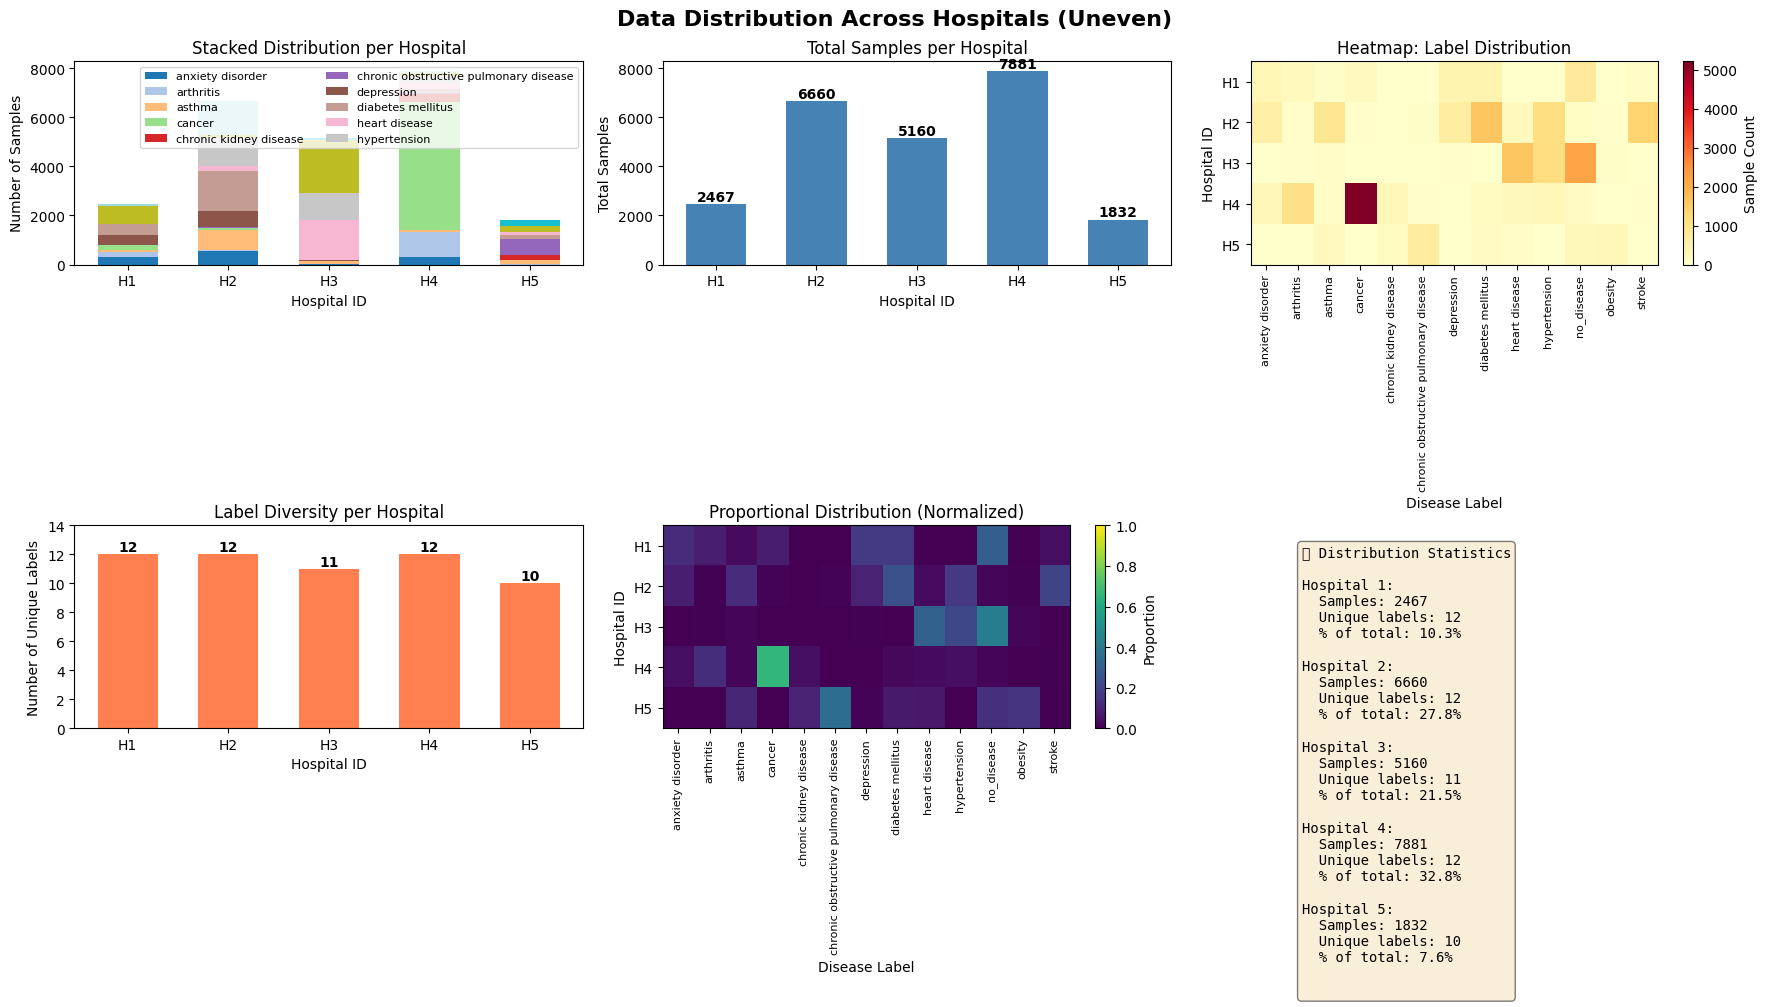


✅ Distribution visualization saved to: /content/fed_clinicalbert_outputs/client_distribution.png


In [8]:

#  VISUALIZE CLIENT DATA DISTRIBUTION

def plot_client_distribution(client_dfs, le):
    """Visualize the uneven distribution of labels across clients"""
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle('Data Distribution Across Hospitals (Uneven)', fontsize=16, fontweight='bold')

    # Prepare data
    all_labels = le.classes_
    data_matrix = np.zeros((len(client_dfs), len(all_labels)))

    for i, cdf in enumerate(client_dfs):
        label_counts = Counter(cdf['label'])
        for j, label in enumerate(all_labels):
            data_matrix[i, j] = label_counts.get(label, 0)

    # Plot 1: Stacked bar chart
    ax = axes[0, 0]
    bottom = np.zeros(len(client_dfs))
    colors = plt.cm.tab20(np.linspace(0, 1, len(all_labels)))

    for j, label in enumerate(all_labels):
        ax.bar(range(len(client_dfs)), data_matrix[:, j], bottom=bottom,
               label=label if j < 10 else None, color=colors[j], width=0.6)
        bottom += data_matrix[:, j]

    ax.set_xlabel('Hospital ID')
    ax.set_ylabel('Number of Samples')
    ax.set_title('Stacked Distribution per Hospital')
    ax.legend(loc='upper right', fontsize=8, ncol=2)
    ax.set_xticks(range(len(client_dfs)))
    ax.set_xticklabels([f'H{i+1}' for i in range(len(client_dfs))])

    # Plot 2: Total samples per client
    ax = axes[0, 1]
    totals = data_matrix.sum(axis=1)
    bars = ax.bar(range(len(client_dfs)), totals, color='steelblue', width=0.6)
    ax.set_xlabel('Hospital ID')
    ax.set_ylabel('Total Samples')
    ax.set_title('Total Samples per Hospital')
    ax.set_xticks(range(len(client_dfs)))
    ax.set_xticklabels([f'H{i+1}' for i in range(len(client_dfs))])

    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}', ha='center', va='bottom', fontsize=10, fontweight='bold')

    # Plot 3: Heatmap
    ax = axes[0, 2]
    im = ax.imshow(data_matrix, cmap='YlOrRd', aspect='auto')
    ax.set_xlabel('Disease Label')
    ax.set_ylabel('Hospital ID')
    ax.set_title('Heatmap: Label Distribution')
    ax.set_yticks(range(len(client_dfs)))
    ax.set_yticklabels([f'H{i+1}' for i in range(len(client_dfs))])
    ax.set_xticks(range(len(all_labels)))
    ax.set_xticklabels(all_labels, rotation=90, fontsize=8)
    plt.colorbar(im, ax=ax, label='Sample Count')

    # Plot 4: Label diversity per client
    ax = axes[1, 0]
    label_diversity = (data_matrix > 0).sum(axis=1)
    bars = ax.bar(range(len(client_dfs)), label_diversity, color='coral', width=0.6)
    ax.set_xlabel('Hospital ID')
    ax.set_ylabel('Number of Unique Labels')
    ax.set_title('Label Diversity per Hospital')
    ax.set_xticks(range(len(client_dfs)))
    ax.set_xticklabels([f'H{i+1}' for i in range(len(client_dfs))])
    ax.set_ylim([0, len(all_labels) + 1])

    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}', ha='center', va='bottom', fontsize=10, fontweight='bold')

    # Plot 5: Proportional distribution
    ax = axes[1, 1]
    prop_matrix = data_matrix / data_matrix.sum(axis=1, keepdims=True)
    im = ax.imshow(prop_matrix, cmap='viridis', aspect='auto', vmin=0, vmax=1)
    ax.set_xlabel('Disease Label')
    ax.set_ylabel('Hospital ID')
    ax.set_title('Proportional Distribution (Normalized)')
    ax.set_yticks(range(len(client_dfs)))
    ax.set_yticklabels([f'H{i+1}' for i in range(len(client_dfs))])
    ax.set_xticks(range(len(all_labels)))
    ax.set_xticklabels(all_labels, rotation=90, fontsize=8)
    plt.colorbar(im, ax=ax, label='Proportion')

    # Plot 6: Sample distribution statistics
    ax = axes[1, 2]
    ax.axis('off')
    stats_text = "📊 Distribution Statistics\n\n"
    for i, cdf in enumerate(client_dfs):
        stats_text += f"Hospital {i+1}:\n"
        stats_text += f"  Samples: {len(cdf)}\n"
        stats_text += f"  Unique labels: {len(Counter(cdf['label']))}\n"
        stats_text += f"  % of total: {len(cdf)/len(train_df)*100:.1f}%\n\n"

    ax.text(0.1, 0.9, stats_text, transform=ax.transAxes,
            fontsize=10, verticalalignment='top', fontfamily='monospace',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    plt.tight_layout()
    plt.savefig(SAVE_DIR / 'client_distribution.png', dpi=150, bbox_inches='tight')
    plt.show()

    print("\n✅ Distribution visualization saved to:", SAVE_DIR / 'client_distribution.png')

plot_client_distribution(client_dfs, le)


###Dataset and Tokenizer

In [9]:

from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

class ClinicalDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=256):
        self.texts = df["text"].tolist()
        self.labels = df["label_id"].tolist()
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self): return len(self.texts)

    def __getitem__(self, idx):
        enc = self.tokenizer(
            self.texts[idx],
            padding="max_length",
            truncation=True,
            max_length=self.max_len,
            return_tensors="pt"
        )
        item = {k: v.squeeze(0) for k,v in enc.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

print("✅ Tokenizer and Dataset classes loaded")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


✅ Tokenizer and Dataset classes loaded


In [10]:
#class weights and loss func

def get_class_weights(df, num_labels):
    # counts = np.bincount(df["label_id"].values, minlength=num_labels).astype(float)
    # weights = counts.sum() / (counts + 1e-6)
    # weights = weights / weights.mean()
    # return torch.tensor(weights, dtype=torch.float32).to(device)
    """
    Compute class weights for imbalanced data
    Handles cases where not all classes are present in the local dataset
    """
    y = df["label_id"].values

    # Get unique classes present in this client's data
    present_classes = np.unique(y)

    # Compute weights only for present classes
    class_weights_present = compute_class_weight(
        'balanced',
        classes=present_classes,
        y=y
    )

    # Create full weight array for all classes
    # Classes not present in this client get weight = 1.0 (neutral)
    class_weights_full = np.ones(num_labels, dtype=np.float32)

    # Fill in weights for present classes
    for i, class_id in enumerate(present_classes):
        class_weights_full[class_id] = class_weights_present[i]

    return torch.tensor(class_weights_full, dtype=torch.float32).to(device)


class FocalLoss(nn.Module):
    def __init__(self, weight=None, gamma=2.0, reduction="mean"):
        super().__init__()
        self.weight = weight
        self.gamma = gamma
        self.reduction = reduction
        self.ce = nn.CrossEntropyLoss(weight=weight, reduction="none")

    def forward(self, logits, targets):
        ce = self.ce(logits, targets)
        pt = torch.exp(-ce)
        loss = (1-pt)**self.gamma * ce
        if self.reduction=="mean": return loss.mean()
        if self.reduction=="sum": return loss.sum()
        return loss

print("✅ Class weights and loss functions defined")


✅ Class weights and loss functions defined


In [11]:
def create_model(num_labels, trainable_layers=TRAINABLE_LAYERS):
    """
    Create ClinicalBERT model with selective layer freezing
    - Always unfreeze: classifier head, embeddings, and LayerNorms
    - Freeze remaining layers except first `trainable_layers` encoder layers
    """
    model = AutoModelForSequenceClassification.from_pretrained(
        MODEL_NAME, num_labels=num_labels)

    # First, freeze ALL parameters
    for param in model.parameters():
        param.requires_grad = False

    # 1. Always unfreeze classifier head
    for param in model.classifier.parameters():
        param.requires_grad = True

    # 2. Always unfreeze embeddings
    for param in model.bert.embeddings.parameters():
        param.requires_grad = True

    # 3. Unfreeze first N encoder layers + their LayerNorms
    for i in range(trainable_layers):
        layer = model.bert.encoder.layer[i]
        for param in layer.parameters():
            param.requires_grad = True

    # 4. Always unfreeze ALL LayerNorms for adaptability
    for name, module in model.named_modules():
        if isinstance(module, nn.LayerNorm):
            for param in module.parameters():
                param.requires_grad = True

    # Print trainable parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"📊 Model Parameters: {trainable_params:,} / {total_params:,} trainable ({100*trainable_params/total_params:.2f}%)")

    return model.to(device)

print("✅ Model creation function defined")



✅ Model creation function defined


In [12]:
# PRUNING AND QUANTIZATION UTILITIES

def apply_pruning(model, amount=PRUNING_AMOUNT):
    """
    Apply structured pruning to linear layers
    """
    prunable_modules = []

    for name, module in model.named_modules():
        if isinstance(module, nn.Linear):
            # Don't prune classifier head
            if 'classifier' not in name:
                prunable_modules.append((module, 'weight'))

    # Apply L1 unstructured pruning
    for module, param_name in prunable_modules:
        prune.l1_unstructured(module, name=param_name, amount=amount)

    return model

def calculate_sparsity(model):
    """Calculate overall sparsity of the model"""
    zero_params = 0
    total_params = 0

    for module in model.modules():
        if isinstance(module, nn.Linear):
            if hasattr(module, 'weight_orig'):  # Pruned layer
                weight = module.weight_orig
            else:
                weight = module.weight
            zero_params += (weight == 0).sum().item()
            total_params += weight.numel()

    sparsity = 100.0 * zero_params / total_params if total_params > 0 else 0.0
    return sparsity

def make_pruning_permanent(model):
    """Remove pruning reparametrization and make it permanent"""
    for module in model.modules():
        if isinstance(module, nn.Linear) and hasattr(module, 'weight_orig'):
            prune.remove(module, 'weight')
    return model

print("✅ Pruning and quantization utilities defined")


✅ Pruning and quantization utilities defined


In [13]:
# training func

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    preds, targs, total_loss = [], [], 0.0

    for batch in loader:
        for k in ["input_ids","attention_mask","labels"]:
            batch[k] = batch[k].to(device)

        out = model(input_ids=batch["input_ids"],
                    attention_mask=batch["attention_mask"],
                    labels= batch["labels"])

        total_loss += out.loss.item() * batch["labels"].size(0)

        logits = out.logits
        pred = logits.argmax(-1).detach().cpu().numpy()
        targ = batch["labels"].detach().cpu().numpy()
        preds.append(pred); targs.append(targ)

    preds = np.concatenate(preds); targs = np.concatenate(targs)
    avg_loss = total_loss / len(targs)
    acc = accuracy_score(targs, preds)
    f1 = f1_score(targs, preds, average="macro")

    return avg_loss, acc, f1, (preds, targs)

def train_local(model, train_loader, val_loader, epochs, lr, weight_decay,
                class_weights=None, use_focal=False, patience=2):
    if use_focal:
        loss_fn = FocalLoss(weight=class_weights)
    else:
        loss_fn = nn.CrossEntropyLoss(weight=class_weights)

    optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=lr, weight_decay=weight_decay)
    num_training_steps = epochs * len(train_loader)
    scheduler = get_linear_schedule_with_warmup(optimizer,num_warmup_steps=int(0.1 * num_training_steps),
                                                num_training_steps=num_training_steps)

    best_f1, best_state, no_improve = -1.0, None, 0
    epoch_losses = []

    for ep in range(1, epochs+1):
        model.train()
        total_loss = 0.0

        pbar = tqdm(train_loader, desc=f"  Epoch {ep}/{epochs}", leave=False)
        for batch in pbar:
            for k in ["input_ids","attention_mask","labels"]:
                batch[k] = batch[k].to(device)

            out = model(input_ids=batch["input_ids"],
                       attention_mask=batch["attention_mask"],
                       labels=None)

            loss = loss_fn(out.logits, batch["labels"])
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()

            total_loss += loss.item()
            pbar.set_postfix({'loss': f'{loss.item():.4f}'})

        avg_epoch_loss = total_loss / len(train_loader)
        epoch_losses.append(avg_epoch_loss)

        # val
        # Validation
        val_loss, val_acc, val_f1, _ = evaluate(model, val_loader)

        if val_f1 > best_f1:
            best_f1 = val_f1
            best_state = {k:v.detach().cpu().clone() for k,v in model.state_dict().items()}
            no_improve = 0
        else:
            no_improve += 1

        if no_improve >= patience:
            break

    # Load best weights
    if best_state is not None:
        model.load_state_dict(best_state)

    final_loss = epoch_losses[-1] if epoch_losses else 0.0
    return model, final_loss

print("✅ Training functions defined")


✅ Training functions defined


In [14]:
# federated averaging
def fedavg_weighted(states, sizes):
    total = float(sum(sizes))
    out = {}
    for k in states[0].keys():
      # Stack tensors and compute weighted average
        stacked = torch.stack([states[i][k].float() for i in range(len(states))])
        weights = torch.tensor([sizes[i]/total for i in range(len(states))]).view(-1, *([1]*(stacked.dim()-1)))
        out[k] = (stacked * weights).sum(dim=0)

    return out

print("✅ Federated averaging function defined")

✅ Federated averaging function defined


In [15]:
def run_federated_training(client_dfs, test_df, tokenizer, le,
                          federated_rounds=FEDERATED_ROUNDS,
                          local_epochs=LOCAL_EPOCHS,
                          batch_size=BATCH_SIZE,
                          learning_rate=LEARNING_RATE,
                          weight_decay=WEIGHT_DECAY,
                          max_len=MAX_LEN,
                          use_class_weights=USE_CLASS_WEIGHTS,
                          use_focal=USE_FOCAL_LOSS,
                          early_stop_patience=EARLY_STOP_PATIENCE,
                          enable_pruning=ENABLE_PRUNING,
                          pruning_start_round=PRUNING_START_ROUND):

    # Initialize history
    history = {
        'round': [],
        'loss': [],
        'accuracy': [],
        'f1': [],
        'sparsity': []
    }

    # Create global model
    global_model = create_model(len(le.classes_), trainable_layers=TRAINABLE_LAYERS)

    # Prepare test loader
    test_ds = ClinicalDataset(test_df, tokenizer, max_len=max_len)
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False,
                            num_workers=0, pin_memory=True)

    best_f1 = -1.0
    best_state = None
    no_improve_rounds = 0

    print("\n" + "=" * 70)
    print("🚀 STARTING FEDERATED TRAINING")
    print("=" * 70)

    for round_num in range(1, federated_rounds + 1):
        print("\n" + "=" * 70)
        print(f"📍 ROUND {round_num}/{federated_rounds}")
        print("=" * 70)

        client_states = []
        client_sizes = []

        # Train on each hospital
        for cid, cdf in enumerate(client_dfs):
            # Split into train/val
            mask = cdf["idx"].apply(lambda x: (hash(x) % 10) < 8)  # 80/20 split
            ctrain = cdf[mask].reset_index(drop=True)
            cval = cdf[~mask].reset_index(drop=True)

            print(f"\n🏥 Hospital {cid+1}/{len(client_dfs)} ({len(ctrain)} samples)")

            # Print label distribution for this client
            label_dist = Counter(ctrain['label'])
            print(f"   Training labels: {len(label_dist)} unique classes")
            print(f"   Top 3 diseases: {label_dist.most_common(3)}")
            print(f"   Train/Val split: {len(ctrain)}/{len(cval)} ({len(ctrain)/len(cdf)*100:.1f}%/{len(cval)/len(cdf)*100:.1f}%)")

            # Create dataloaders
            train_ds = ClinicalDataset(ctrain, tokenizer, max_len=max_len)
            val_ds = ClinicalDataset(cval, tokenizer, max_len=max_len)
            train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,
                                     num_workers=0, pin_memory=True)
            val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False,
                                   num_workers=0, pin_memory=True)

            # Create local model and load global weights
            local_model = create_model(len(le.classes_), trainable_layers=TRAINABLE_LAYERS)
            local_model.load_state_dict(global_model.state_dict())

            # Compute class weights
            class_w = get_class_weights(ctrain, len(le.classes_)) if use_class_weights else None

            # Train locally
            local_model, train_loss = train_local(
                local_model, train_loader, val_loader,
                epochs=local_epochs,
                lr=learning_rate,
                weight_decay=weight_decay,
                class_weights=class_w,
                use_focal=use_focal,
                patience=2
            )

            print(f"   ✅ Loss: {train_loss:.4f}")

            # Store client state
            client_states.append({k:v.detach().cpu().clone() for k,v in local_model.state_dict().items()})
            client_sizes.append(len(ctrain))

            # Clean up
            del local_model, train_ds, val_ds, train_loader, val_loader
            torch.cuda.empty_cache()
            gc.collect()

        # Aggregate models
        print(f"\n🔄 Aggregating...")
        global_state = fedavg_weighted(client_states, client_sizes)
        global_model.load_state_dict(global_state)

        # Apply pruning after specified round
        if enable_pruning and round_num >= pruning_start_round:
            print(f"✂️  Applying pruning (amount={PRUNING_AMOUNT})...")
            global_model = apply_pruning(global_model, amount=PRUNING_AMOUNT)

        # Calculate sparsity
        sparsity = calculate_sparsity(global_model)

        # Evaluate on test set
        print(f"📊 Evaluating...")
        test_loss, test_acc, test_f1, (preds, targs) = evaluate(global_model, test_loader)

        # Update history
        history['round'].append(round_num)
        history['loss'].append(test_loss)
        history['accuracy'].append(test_acc)
        history['f1'].append(test_f1)
        history['sparsity'].append(sparsity)

        # Print results
        print(f"\n📈 Round {round_num} Results:")
        print(f"   Loss: {test_loss:.4f}")
        print(f"   Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")
        print(f"   F1 Score: {test_f1:.4f} ← MACRO F1 (good for imbalanced data)")
        print(f"   Sparsity: {sparsity:.2f}%")

        # Check for improvement
        if test_f1 > best_f1:
            best_f1 = test_f1
            best_state = {k:v.detach().cpu().clone() for k,v in global_model.state_dict().items()}
            no_improve_rounds = 0
            print(f"   💾 New best! Saving...")

            # Save best model
            torch.save(best_state, SAVE_DIR / 'best_global_model.pt')
        else:
            no_improve_rounds += 1

        # Early stopping
        if no_improve_rounds >= early_stop_patience:
            print(f"\n⏹️  Early stopping triggered after {round_num} rounds (no improvement for {early_stop_patience} rounds)")
            break

    # Load best model
    if best_state is not None:
        global_model.load_state_dict(best_state)

    # Make pruning permanent if applied
    if enable_pruning:
        global_model = make_pruning_permanent(global_model)

    print("\n" + "=" * 70)
    print("✅ FEDERATED TRAINING COMPLETE")
    print("=" * 70)
    print(f"Best F1 Score: {best_f1:.4f}")

    return global_model, history


### K‑Fold CV + Optuna Hyperparameter Optimization


In [16]:

# from sklearn.model_selection import KFold

# KFOLDS = 3
# FED_ROUNDS_PER_TRIAL = 1
# MAX_TRIALS = 10

# def objective(trial):
#     params = {
#         "lr": trial.suggest_float("lr", 1e-6, 5e-5, log=True),
#         "weight_decay": trial.suggest_float("weight_decay", 0.0, 0.1),
#         "batch_size": trial.suggest_categorical("batch_size", [8, 12, 16]),
#         "max_len": trial.suggest_categorical("max_len", [192, 256, 320]),
#         "local_epochs": trial.suggest_int("local_epochs", 1, 3),
#         "use_class_weights": True,
#         "use_focal": trial.suggest_categorical("use_focal", [False, True]),
#         "patience": 2,
#     }
#     kf = KFold(n_splits=KFOLDS, shuffle=True, random_state=42)
#     f1_scores = []
#     X = train_df.index.values
#     for fold, (tr, va) in enumerate(kf.split(X)):
#         fold_train = train_df.iloc[tr].reset_index(drop=True)
#         fold_test  = train_df.iloc[va].reset_index(drop=True)
#         fold_clients = dirichlet_partition(fold_train, NUM_CLIENTS, DIRICHLET_ALPHA)
#         last_f1 = -1.0
#         for _ in range(FED_ROUNDS_PER_TRIAL):
#             _, _, f1 = run_federated_round(fold_clients, params, fold_test, tokenizer, le)
#             last_f1 = f1
#         f1_scores.append(last_f1)
#         trial.report(float(np.mean(f1_scores)), fold)
#         if trial.should_prune():
#             raise optuna.TrialPruned()
#     return float(np.mean(f1_scores))

# study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=MAX_TRIALS, show_progress_bar=True)

# print("Best value (macro-F1):", study.best_value)
# print("Best params:", study.best_params)

# import json, os
# with open(os.path.join(SAVE_DIR, "best_params.json"), "w") as f:
#     json.dump(study.best_params, f, indent=2)


In [17]:
# # Cap training data to 5,000 rows
# TRAIN_CAP = 5000
# train_small = train_df.sample(n=min(TRAIN_CAP, len(train_df)), random_state=42).reset_index(drop=True)
# print({"train_full": len(train_df), "train_small": len(train_small)})

# KFOLDS = 2
# FED_ROUNDS_PER_TRIAL = 1   # keep at 1
# MAX_TRIALS = 3

# def objective(trial):

#     params = {
#         "lr": trial.suggest_categorical("lr", [2e-5]),
#         "weight_decay": trial.suggest_categorical("weight_decay", [0.01]),
#         "batch_size": trial.suggest_categorical("batch_size", [8]),
#         "max_len": trial.suggest_categorical("max_len", [192]),
#         "local_epochs": trial.suggest_categorical("local_epochs", [8]),
#         "use_class_weights": True,
#         "use_focal": trial.suggest_categorical("use_focal", [False]),
#         "patience": 2,
#     }

#     kf = KFold(n_splits=KFOLDS, shuffle=True, random_state=42)
#     f1_scores = []
#     X = train_small.index.values

#     for fold, (tr, va) in enumerate(kf.split(X)):
#         fold_train = train_small.iloc[tr].reset_index(drop=True)
#         fold_test  = train_small.iloc[va].reset_index(drop=True)

#         # existing uneven client split + one federated round
#         fold_clients = dirichlet_partition(fold_train, NUM_CLIENTS, DIRICHLET_ALPHA)
#         _, _, f1 = run_federated_round(fold_clients, params, fold_test, tokenizer, le)
#         f1_scores.append(float(f1))

#         trial.report(float(np.mean(f1_scores)), fold)
#         if trial.should_prune():
#             raise optuna.TrialPruned()

#     return float(np.mean(f1_scores))

# study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=MAX_TRIALS, show_progress_bar=True)

# print("Best value (macro-F1):", study.best_value)
# print("Best params:", study.best_params)

# # save so the later cells work unchanged
# with open(os.path.join(SAVE_DIR, "best_params.json"), "w") as f:
#     json.dump(study.best_params, f, indent=2)




### 5) Final Training with Best Hyperparameters


In [ ]:

# RUN FEDERATED TRAINING

final_model, history = run_federated_training(
    client_dfs=client_dfs,
    test_df=test_df,
    tokenizer=tokenizer,
    le=le
)

# Save history
import json
with open(SAVE_DIR / 'training_history.json', 'w') as f:
    json.dump(history, f, indent=2)

print(f"\n📁 Training history saved to: {SAVE_DIR / 'training_history.json'}")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


📊 Model Parameters: 51,051,277 / 108,320,269 trainable (47.13%)

🚀 STARTING FEDERATED TRAINING

📍 ROUND 1/10

🏥 Hospital 1/5 (1979 samples)
   Training labels: 12 unique classes
   Top 3 diseases: [('no_disease', 592), ('diabetes mellitus', 350), ('depression', 342)]
   Train/Val split: 1979/488 (80.2%/19.8%)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


📊 Model Parameters: 51,051,277 / 108,320,269 trainable (47.13%)


  Epoch 1/10:   0%|          | 0/124 [00:00<?, ?it/s]

  Epoch 2/10:   0%|          | 0/124 [00:00<?, ?it/s]

  Epoch 3/10:   0%|          | 0/124 [00:00<?, ?it/s]

  Epoch 4/10:   0%|          | 0/124 [00:00<?, ?it/s]

  Epoch 5/10:   0%|          | 0/124 [00:00<?, ?it/s]

  Epoch 6/10:   0%|          | 0/124 [00:00<?, ?it/s]

  Epoch 7/10:   0%|          | 0/124 [00:00<?, ?it/s]

  Epoch 8/10:   0%|          | 0/124 [00:00<?, ?it/s]

  Epoch 9/10:   0%|          | 0/124 [00:00<?, ?it/s]

  Epoch 10/10:   0%|          | 0/124 [00:00<?, ?it/s]

   ✅ Loss: 1.4286

🏥 Hospital 2/5 (5285 samples)
   Training labels: 12 unique classes
   Top 3 diseases: [('diabetes mellitus', 1317), ('stroke', 1080), ('hypertension', 883)]
   Train/Val split: 5285/1375 (79.4%/20.6%)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


📊 Model Parameters: 51,051,277 / 108,320,269 trainable (47.13%)


  Epoch 1/10:   0%|          | 0/331 [00:00<?, ?it/s]

  Epoch 2/10:   0%|          | 0/331 [00:00<?, ?it/s]

  Epoch 3/10:   0%|          | 0/331 [00:00<?, ?it/s]

  Epoch 4/10:   0%|          | 0/331 [00:00<?, ?it/s]

  Epoch 5/10:   0%|          | 0/331 [00:00<?, ?it/s]

  Epoch 6/10:   0%|          | 0/331 [00:00<?, ?it/s]

  Epoch 7/10:   0%|          | 0/331 [00:00<?, ?it/s]

  Epoch 8/10:   0%|          | 0/331 [00:00<?, ?it/s]

  Epoch 9/10:   0%|          | 0/331 [00:00<?, ?it/s]

  Epoch 10/10:   0%|          | 0/331 [00:00<?, ?it/s]

   ✅ Loss: 0.9684

🏥 Hospital 3/5 (4133 samples)
   Training labels: 10 unique classes
   Top 3 diseases: [('no_disease', 1748), ('heart disease', 1267), ('hypertension', 894)]
   Train/Val split: 4133/1027 (80.1%/19.9%)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


📊 Model Parameters: 51,051,277 / 108,320,269 trainable (47.13%)


  Epoch 1/10:   0%|          | 0/259 [00:00<?, ?it/s]

  Epoch 2/10:   0%|          | 0/259 [00:00<?, ?it/s]

  Epoch 3/10:   0%|          | 0/259 [00:00<?, ?it/s]

  Epoch 4/10:   0%|          | 0/259 [00:00<?, ?it/s]

  Epoch 5/10:   0%|          | 0/259 [00:00<?, ?it/s]

  Epoch 6/10:   0%|          | 0/259 [00:00<?, ?it/s]

  Epoch 7/10:   0%|          | 0/259 [00:00<?, ?it/s]

  Epoch 8/10:   0%|          | 0/259 [00:00<?, ?it/s]

  Epoch 9/10:   0%|          | 0/259 [00:00<?, ?it/s]

  Epoch 10/10:   0%|          | 0/259 [00:00<?, ?it/s]

   ✅ Loss: 0.8971

🏥 Hospital 4/5 (6262 samples)
   Training labels: 12 unique classes
   Top 3 diseases: [('cancer', 4154), ('arthritis', 787), ('chronic kidney disease', 259)]
   Train/Val split: 6262/1619 (79.5%/20.5%)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


📊 Model Parameters: 51,051,277 / 108,320,269 trainable (47.13%)


  Epoch 1/10:   0%|          | 0/392 [00:00<?, ?it/s]

  Epoch 2/10:   0%|          | 0/392 [00:00<?, ?it/s]

  Epoch 3/10:   0%|          | 0/392 [00:00<?, ?it/s]

  Epoch 4/10:   0%|          | 0/392 [00:00<?, ?it/s]

  Epoch 5/10:   0%|          | 0/392 [00:00<?, ?it/s]

  Epoch 6/10:   0%|          | 0/392 [00:00<?, ?it/s]

  Epoch 7/10:   0%|          | 0/392 [00:00<?, ?it/s]

  Epoch 8/10:   0%|          | 0/392 [00:00<?, ?it/s]

  Epoch 9/10:   0%|          | 0/392 [00:00<?, ?it/s]

   ✅ Loss: 0.8558

🏥 Hospital 5/5 (1462 samples)
   Training labels: 9 unique classes
   Top 3 diseases: [('chronic obstructive pulmonary disease', 531), ('obesity', 223), ('no_disease', 194)]
   Train/Val split: 1462/370 (79.8%/20.2%)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


📊 Model Parameters: 51,051,277 / 108,320,269 trainable (47.13%)


  Epoch 1/10:   0%|          | 0/92 [00:00<?, ?it/s]

  Epoch 2/10:   0%|          | 0/92 [00:00<?, ?it/s]

  Epoch 3/10:   0%|          | 0/92 [00:00<?, ?it/s]

  Epoch 4/10:   0%|          | 0/92 [00:00<?, ?it/s]

  Epoch 5/10:   0%|          | 0/92 [00:00<?, ?it/s]

  Epoch 6/10:   0%|          | 0/92 [00:00<?, ?it/s]

  Epoch 7/10:   0%|          | 0/92 [00:00<?, ?it/s]

  Epoch 8/10:   0%|          | 0/92 [00:00<?, ?it/s]

  Epoch 9/10:   0%|          | 0/92 [00:00<?, ?it/s]

  Epoch 10/10:   0%|          | 0/92 [00:00<?, ?it/s]

   ✅ Loss: 1.6393

🔄 Aggregating...
📊 Evaluating...

📈 Round 1 Results:
   Loss: 2.0843
   Accuracy: 0.2955 (29.55%)
   F1 Score: 0.1658 ← MACRO F1 (good for imbalanced data)
   Sparsity: 0.00%
   💾 New best! Saving...

📍 ROUND 2/10

🏥 Hospital 1/5 (1979 samples)
   Training labels: 12 unique classes
   Top 3 diseases: [('no_disease', 592), ('diabetes mellitus', 350), ('depression', 342)]
   Train/Val split: 1979/488 (80.2%/19.8%)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


📊 Model Parameters: 51,051,277 / 108,320,269 trainable (47.13%)


  Epoch 1/10:   0%|          | 0/124 [00:00<?, ?it/s]

  Epoch 2/10:   0%|          | 0/124 [00:00<?, ?it/s]

  Epoch 3/10:   0%|          | 0/124 [00:00<?, ?it/s]

  Epoch 4/10:   0%|          | 0/124 [00:00<?, ?it/s]

  Epoch 5/10:   0%|          | 0/124 [00:00<?, ?it/s]

  Epoch 6/10:   0%|          | 0/124 [00:00<?, ?it/s]

  Epoch 7/10:   0%|          | 0/124 [00:00<?, ?it/s]

  Epoch 8/10:   0%|          | 0/124 [00:00<?, ?it/s]

   ✅ Loss: 0.7449

🏥 Hospital 2/5 (5285 samples)
   Training labels: 12 unique classes
   Top 3 diseases: [('diabetes mellitus', 1317), ('stroke', 1080), ('hypertension', 883)]
   Train/Val split: 5285/1375 (79.4%/20.6%)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


📊 Model Parameters: 51,051,277 / 108,320,269 trainable (47.13%)


  Epoch 1/10:   0%|          | 0/331 [00:00<?, ?it/s]

  Epoch 2/10:   0%|          | 0/331 [00:00<?, ?it/s]

  Epoch 3/10:   0%|          | 0/331 [00:00<?, ?it/s]

  Epoch 4/10:   0%|          | 0/331 [00:00<?, ?it/s]

  Epoch 5/10:   0%|          | 0/331 [00:00<?, ?it/s]

   ✅ Loss: 0.8364

🏥 Hospital 3/5 (4133 samples)
   Training labels: 10 unique classes
   Top 3 diseases: [('no_disease', 1748), ('heart disease', 1267), ('hypertension', 894)]
   Train/Val split: 4133/1027 (80.1%/19.9%)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


📊 Model Parameters: 51,051,277 / 108,320,269 trainable (47.13%)


  Epoch 1/10:   0%|          | 0/259 [00:00<?, ?it/s]

  Epoch 2/10:   0%|          | 0/259 [00:00<?, ?it/s]

  Epoch 3/10:   0%|          | 0/259 [00:00<?, ?it/s]

  Epoch 4/10:   0%|          | 0/259 [00:00<?, ?it/s]

  Epoch 5/10:   0%|          | 0/259 [00:00<?, ?it/s]

  Epoch 6/10:   0%|          | 0/259 [00:00<?, ?it/s]

  Epoch 7/10:   0%|          | 0/259 [00:00<?, ?it/s]

  Epoch 8/10:   0%|          | 0/259 [00:00<?, ?it/s]

  Epoch 9/10:   0%|          | 0/259 [00:00<?, ?it/s]

   ✅ Loss: 0.4557

🏥 Hospital 4/5 (6262 samples)
   Training labels: 12 unique classes
   Top 3 diseases: [('cancer', 4154), ('arthritis', 787), ('chronic kidney disease', 259)]
   Train/Val split: 6262/1619 (79.5%/20.5%)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


📊 Model Parameters: 51,051,277 / 108,320,269 trainable (47.13%)


  Epoch 1/10:   0%|          | 0/392 [00:00<?, ?it/s]

  Epoch 2/10:   0%|          | 0/392 [00:00<?, ?it/s]

  Epoch 3/10:   0%|          | 0/392 [00:00<?, ?it/s]

  Epoch 4/10:   0%|          | 0/392 [00:00<?, ?it/s]

  Epoch 5/10:   0%|          | 0/392 [00:00<?, ?it/s]

  Epoch 6/10:   0%|          | 0/392 [00:00<?, ?it/s]

  Epoch 7/10:   0%|          | 0/392 [00:00<?, ?it/s]

  Epoch 8/10:   0%|          | 0/392 [00:00<?, ?it/s]

   ✅ Loss: 0.4532

🏥 Hospital 5/5 (1462 samples)
   Training labels: 9 unique classes
   Top 3 diseases: [('chronic obstructive pulmonary disease', 531), ('obesity', 223), ('no_disease', 194)]
   Train/Val split: 1462/370 (79.8%/20.2%)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


📊 Model Parameters: 51,051,277 / 108,320,269 trainable (47.13%)


  Epoch 1/10:   0%|          | 0/92 [00:00<?, ?it/s]

  Epoch 2/10:   0%|          | 0/92 [00:00<?, ?it/s]

  Epoch 3/10:   0%|          | 0/92 [00:00<?, ?it/s]

  Epoch 4/10:   0%|          | 0/92 [00:00<?, ?it/s]

  Epoch 5/10:   0%|          | 0/92 [00:00<?, ?it/s]

  Epoch 6/10:   0%|          | 0/92 [00:00<?, ?it/s]

  Epoch 7/10:   0%|          | 0/92 [00:00<?, ?it/s]

   ✅ Loss: 0.5741

🔄 Aggregating...
📊 Evaluating...

📈 Round 2 Results:
   Loss: 1.2806
   Accuracy: 0.6530 (65.30%)
   F1 Score: 0.5190 ← MACRO F1 (good for imbalanced data)
   Sparsity: 0.00%
   💾 New best! Saving...

📍 ROUND 3/10

🏥 Hospital 1/5 (1979 samples)
   Training labels: 12 unique classes
   Top 3 diseases: [('no_disease', 592), ('diabetes mellitus', 350), ('depression', 342)]
   Train/Val split: 1979/488 (80.2%/19.8%)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


📊 Model Parameters: 51,051,277 / 108,320,269 trainable (47.13%)


  Epoch 1/10:   0%|          | 0/124 [00:00<?, ?it/s]

  Epoch 2/10:   0%|          | 0/124 [00:00<?, ?it/s]

  Epoch 3/10:   0%|          | 0/124 [00:00<?, ?it/s]

   ✅ Loss: 0.9936

🏥 Hospital 2/5 (5285 samples)
   Training labels: 12 unique classes
   Top 3 diseases: [('diabetes mellitus', 1317), ('stroke', 1080), ('hypertension', 883)]
   Train/Val split: 5285/1375 (79.4%/20.6%)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


📊 Model Parameters: 51,051,277 / 108,320,269 trainable (47.13%)


  Epoch 1/10:   0%|          | 0/331 [00:00<?, ?it/s]

  Epoch 2/10:   0%|          | 0/331 [00:00<?, ?it/s]

  Epoch 3/10:   0%|          | 0/331 [00:00<?, ?it/s]

  Epoch 4/10:   0%|          | 0/331 [00:00<?, ?it/s]

  Epoch 5/10:   0%|          | 0/331 [00:00<?, ?it/s]

  Epoch 6/10:   0%|          | 0/331 [00:00<?, ?it/s]

  Epoch 7/10:   0%|          | 0/331 [00:00<?, ?it/s]

   ✅ Loss: 0.4858

🏥 Hospital 3/5 (4133 samples)
   Training labels: 10 unique classes
   Top 3 diseases: [('no_disease', 1748), ('heart disease', 1267), ('hypertension', 894)]
   Train/Val split: 4133/1027 (80.1%/19.9%)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


📊 Model Parameters: 51,051,277 / 108,320,269 trainable (47.13%)


  Epoch 1/10:   0%|          | 0/259 [00:00<?, ?it/s]

  Epoch 2/10:   0%|          | 0/259 [00:00<?, ?it/s]

  Epoch 3/10:   0%|          | 0/259 [00:00<?, ?it/s]

  Epoch 4/10:   0%|          | 0/259 [00:00<?, ?it/s]

   ✅ Loss: 0.5613

🏥 Hospital 4/5 (6262 samples)
   Training labels: 12 unique classes
   Top 3 diseases: [('cancer', 4154), ('arthritis', 787), ('chronic kidney disease', 259)]
   Train/Val split: 6262/1619 (79.5%/20.5%)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


📊 Model Parameters: 51,051,277 / 108,320,269 trainable (47.13%)


  Epoch 1/10:   0%|          | 0/392 [00:00<?, ?it/s]

  Epoch 2/10:   0%|          | 0/392 [00:00<?, ?it/s]

  Epoch 3/10:   0%|          | 0/392 [00:00<?, ?it/s]

  Epoch 4/10:   0%|          | 0/392 [00:00<?, ?it/s]

  Epoch 5/10:   0%|          | 0/392 [00:00<?, ?it/s]

   ✅ Loss: 0.4813

🏥 Hospital 5/5 (1462 samples)
   Training labels: 9 unique classes
   Top 3 diseases: [('chronic obstructive pulmonary disease', 531), ('obesity', 223), ('no_disease', 194)]
   Train/Val split: 1462/370 (79.8%/20.2%)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


📊 Model Parameters: 51,051,277 / 108,320,269 trainable (47.13%)


  Epoch 1/10:   0%|          | 0/92 [00:00<?, ?it/s]

  Epoch 2/10:   0%|          | 0/92 [00:00<?, ?it/s]

  Epoch 3/10:   0%|          | 0/92 [00:00<?, ?it/s]

  Epoch 4/10:   0%|          | 0/92 [00:00<?, ?it/s]

  Epoch 5/10:   0%|          | 0/92 [00:00<?, ?it/s]

   ✅ Loss: 0.4871

🔄 Aggregating...
📊 Evaluating...

📈 Round 3 Results:
   Loss: 1.1398
   Accuracy: 0.6958 (69.58%)
   F1 Score: 0.5892 ← MACRO F1 (good for imbalanced data)
   Sparsity: 0.00%
   💾 New best! Saving...

📍 ROUND 4/10

🏥 Hospital 1/5 (1979 samples)
   Training labels: 12 unique classes
   Top 3 diseases: [('no_disease', 592), ('diabetes mellitus', 350), ('depression', 342)]
   Train/Val split: 1979/488 (80.2%/19.8%)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


📊 Model Parameters: 51,051,277 / 108,320,269 trainable (47.13%)


  Epoch 1/10:   0%|          | 0/124 [00:00<?, ?it/s]

  Epoch 2/10:   0%|          | 0/124 [00:00<?, ?it/s]

  Epoch 3/10:   0%|          | 0/124 [00:00<?, ?it/s]

  Epoch 4/10:   0%|          | 0/124 [00:00<?, ?it/s]

  Epoch 5/10:   0%|          | 0/124 [00:00<?, ?it/s]

  Epoch 6/10:   0%|          | 0/124 [00:00<?, ?it/s]

  Epoch 7/10:   0%|          | 0/124 [00:00<?, ?it/s]

  Epoch 8/10:   0%|          | 0/124 [00:00<?, ?it/s]

  Epoch 9/10:   0%|          | 0/124 [00:00<?, ?it/s]

  Epoch 10/10:   0%|          | 0/124 [00:00<?, ?it/s]

   ✅ Loss: 0.3403

🏥 Hospital 2/5 (5285 samples)
   Training labels: 12 unique classes
   Top 3 diseases: [('diabetes mellitus', 1317), ('stroke', 1080), ('hypertension', 883)]
   Train/Val split: 5285/1375 (79.4%/20.6%)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


📊 Model Parameters: 51,051,277 / 108,320,269 trainable (47.13%)


  Epoch 1/10:   0%|          | 0/331 [00:00<?, ?it/s]

  Epoch 2/10:   0%|          | 0/331 [00:00<?, ?it/s]

  Epoch 3/10:   0%|          | 0/331 [00:00<?, ?it/s]

  Epoch 4/10:   0%|          | 0/331 [00:00<?, ?it/s]

  Epoch 5/10:   0%|          | 0/331 [00:00<?, ?it/s]

   ✅ Loss: 0.4707

🏥 Hospital 3/5 (4133 samples)
   Training labels: 10 unique classes
   Top 3 diseases: [('no_disease', 1748), ('heart disease', 1267), ('hypertension', 894)]
   Train/Val split: 4133/1027 (80.1%/19.9%)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


📊 Model Parameters: 51,051,277 / 108,320,269 trainable (47.13%)


  Epoch 1/10:   0%|          | 0/259 [00:00<?, ?it/s]

  Epoch 2/10:   0%|          | 0/259 [00:00<?, ?it/s]

  Epoch 3/10:   0%|          | 0/259 [00:00<?, ?it/s]

  Epoch 4/10:   0%|          | 0/259 [00:00<?, ?it/s]

  Epoch 5/10:   0%|          | 0/259 [00:00<?, ?it/s]

   ✅ Loss: 0.3473

🏥 Hospital 4/5 (6262 samples)
   Training labels: 12 unique classes
   Top 3 diseases: [('cancer', 4154), ('arthritis', 787), ('chronic kidney disease', 259)]
   Train/Val split: 6262/1619 (79.5%/20.5%)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


📊 Model Parameters: 51,051,277 / 108,320,269 trainable (47.13%)


  Epoch 1/10:   0%|          | 0/392 [00:00<?, ?it/s]

  Epoch 2/10:   0%|          | 0/392 [00:00<?, ?it/s]

  Epoch 3/10:   0%|          | 0/392 [00:00<?, ?it/s]

  Epoch 4/10:   0%|          | 0/392 [00:00<?, ?it/s]

  Epoch 5/10:   0%|          | 0/392 [00:00<?, ?it/s]

  Epoch 6/10:   0%|          | 0/392 [00:00<?, ?it/s]

  Epoch 7/10:   0%|          | 0/392 [00:00<?, ?it/s]

   ✅ Loss: 0.2366

🏥 Hospital 5/5 (1462 samples)
   Training labels: 9 unique classes
   Top 3 diseases: [('chronic obstructive pulmonary disease', 531), ('obesity', 223), ('no_disease', 194)]
   Train/Val split: 1462/370 (79.8%/20.2%)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


📊 Model Parameters: 51,051,277 / 108,320,269 trainable (47.13%)


  Epoch 1/10:   0%|          | 0/92 [00:00<?, ?it/s]

  Epoch 2/10:   0%|          | 0/92 [00:00<?, ?it/s]

  Epoch 3/10:   0%|          | 0/92 [00:00<?, ?it/s]

  Epoch 4/10:   0%|          | 0/92 [00:00<?, ?it/s]

  Epoch 5/10:   0%|          | 0/92 [00:00<?, ?it/s]

   ✅ Loss: 0.3834

🔄 Aggregating...
📊 Evaluating...

📈 Round 4 Results:
   Loss: 1.1582
   Accuracy: 0.7032 (70.32%)
   F1 Score: 0.6241 ← MACRO F1 (good for imbalanced data)
   Sparsity: 0.00%
   💾 New best! Saving...

📍 ROUND 5/10

🏥 Hospital 1/5 (1979 samples)
   Training labels: 12 unique classes
   Top 3 diseases: [('no_disease', 592), ('diabetes mellitus', 350), ('depression', 342)]
   Train/Val split: 1979/488 (80.2%/19.8%)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


📊 Model Parameters: 51,051,277 / 108,320,269 trainable (47.13%)


  Epoch 1/10:   0%|          | 0/124 [00:00<?, ?it/s]

  Epoch 2/10:   0%|          | 0/124 [00:00<?, ?it/s]

  Epoch 3/10:   0%|          | 0/124 [00:00<?, ?it/s]

  Epoch 4/10:   0%|          | 0/124 [00:00<?, ?it/s]

  Epoch 5/10:   0%|          | 0/124 [00:00<?, ?it/s]

  Epoch 6/10:   0%|          | 0/124 [00:00<?, ?it/s]

   ✅ Loss: 0.3795

🏥 Hospital 2/5 (5285 samples)
   Training labels: 12 unique classes
   Top 3 diseases: [('diabetes mellitus', 1317), ('stroke', 1080), ('hypertension', 883)]
   Train/Val split: 5285/1375 (79.4%/20.6%)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


📊 Model Parameters: 51,051,277 / 108,320,269 trainable (47.13%)


  Epoch 1/10:   0%|          | 0/331 [00:00<?, ?it/s]

  Epoch 2/10:   0%|          | 0/331 [00:00<?, ?it/s]

  Epoch 3/10:   0%|          | 0/331 [00:00<?, ?it/s]

  Epoch 4/10:   0%|          | 0/331 [00:00<?, ?it/s]

  Epoch 5/10:   0%|          | 0/331 [00:00<?, ?it/s]

  Epoch 6/10:   0%|          | 0/331 [00:00<?, ?it/s]

  Epoch 7/10:   0%|          | 0/331 [00:00<?, ?it/s]

  Epoch 8/10:   0%|          | 0/331 [00:00<?, ?it/s]

  Epoch 9/10:   0%|          | 0/331 [00:00<?, ?it/s]

   ✅ Loss: 0.1688

🏥 Hospital 3/5 (4133 samples)
   Training labels: 10 unique classes
   Top 3 diseases: [('no_disease', 1748), ('heart disease', 1267), ('hypertension', 894)]
   Train/Val split: 4133/1027 (80.1%/19.9%)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


📊 Model Parameters: 51,051,277 / 108,320,269 trainable (47.13%)


  Epoch 1/10:   0%|          | 0/259 [00:00<?, ?it/s]

  Epoch 2/10:   0%|          | 0/259 [00:00<?, ?it/s]

  Epoch 3/10:   0%|          | 0/259 [00:00<?, ?it/s]

  Epoch 4/10:   0%|          | 0/259 [00:00<?, ?it/s]

  Epoch 5/10:   0%|          | 0/259 [00:00<?, ?it/s]

  Epoch 6/10:   0%|          | 0/259 [00:00<?, ?it/s]

  Epoch 7/10:   0%|          | 0/259 [00:00<?, ?it/s]

  Epoch 8/10:   0%|          | 0/259 [00:00<?, ?it/s]

  Epoch 9/10:   0%|          | 0/259 [00:00<?, ?it/s]

   ✅ Loss: 0.0882

🏥 Hospital 4/5 (6262 samples)
   Training labels: 12 unique classes
   Top 3 diseases: [('cancer', 4154), ('arthritis', 787), ('chronic kidney disease', 259)]
   Train/Val split: 6262/1619 (79.5%/20.5%)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


📊 Model Parameters: 51,051,277 / 108,320,269 trainable (47.13%)


  Epoch 1/10:   0%|          | 0/392 [00:00<?, ?it/s]

  Epoch 2/10:   0%|          | 0/392 [00:00<?, ?it/s]

  Epoch 3/10:   0%|          | 0/392 [00:00<?, ?it/s]

  Epoch 4/10:   0%|          | 0/392 [00:00<?, ?it/s]

  Epoch 5/10:   0%|          | 0/392 [00:00<?, ?it/s]

  Epoch 6/10:   0%|          | 0/392 [00:00<?, ?it/s]

   ✅ Loss: 0.2120

🏥 Hospital 5/5 (1462 samples)
   Training labels: 9 unique classes
   Top 3 diseases: [('chronic obstructive pulmonary disease', 531), ('obesity', 223), ('no_disease', 194)]
   Train/Val split: 1462/370 (79.8%/20.2%)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


📊 Model Parameters: 51,051,277 / 108,320,269 trainable (47.13%)


  Epoch 1/10:   0%|          | 0/92 [00:00<?, ?it/s]

  Epoch 2/10:   0%|          | 0/92 [00:00<?, ?it/s]

  Epoch 3/10:   0%|          | 0/92 [00:00<?, ?it/s]

   ✅ Loss: 0.5646

🔄 Aggregating...
📊 Evaluating...

📈 Round 5 Results:
   Loss: 1.2377
   Accuracy: 0.7188 (71.88%)
   F1 Score: 0.6555 ← MACRO F1 (good for imbalanced data)
   Sparsity: 0.00%
   💾 New best! Saving...

📍 ROUND 6/10

🏥 Hospital 1/5 (1979 samples)
   Training labels: 12 unique classes
   Top 3 diseases: [('no_disease', 592), ('diabetes mellitus', 350), ('depression', 342)]
   Train/Val split: 1979/488 (80.2%/19.8%)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


📊 Model Parameters: 51,051,277 / 108,320,269 trainable (47.13%)


  Epoch 1/10:   0%|          | 0/124 [00:00<?, ?it/s]

  Epoch 2/10:   0%|          | 0/124 [00:00<?, ?it/s]

  Epoch 3/10:   0%|          | 0/124 [00:00<?, ?it/s]

   ✅ Loss: 0.6429

🏥 Hospital 2/5 (5285 samples)
   Training labels: 12 unique classes
   Top 3 diseases: [('diabetes mellitus', 1317), ('stroke', 1080), ('hypertension', 883)]
   Train/Val split: 5285/1375 (79.4%/20.6%)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


📊 Model Parameters: 51,051,277 / 108,320,269 trainable (47.13%)


  Epoch 1/10:   0%|          | 0/331 [00:00<?, ?it/s]

  Epoch 2/10:   0%|          | 0/331 [00:00<?, ?it/s]

  Epoch 3/10:   0%|          | 0/331 [00:00<?, ?it/s]

  Epoch 4/10:   0%|          | 0/331 [00:00<?, ?it/s]

  Epoch 5/10:   0%|          | 0/331 [00:00<?, ?it/s]

  Epoch 6/10:   0%|          | 0/331 [00:00<?, ?it/s]

  Epoch 7/10:   0%|          | 0/331 [00:00<?, ?it/s]

  Epoch 8/10:   0%|          | 0/331 [00:00<?, ?it/s]

   ✅ Loss: 0.1216

🏥 Hospital 3/5 (4133 samples)
   Training labels: 10 unique classes
   Top 3 diseases: [('no_disease', 1748), ('heart disease', 1267), ('hypertension', 894)]
   Train/Val split: 4133/1027 (80.1%/19.9%)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


📊 Model Parameters: 51,051,277 / 108,320,269 trainable (47.13%)


  Epoch 1/10:   0%|          | 0/259 [00:00<?, ?it/s]

  Epoch 2/10:   0%|          | 0/259 [00:00<?, ?it/s]

  Epoch 3/10:   0%|          | 0/259 [00:00<?, ?it/s]

  Epoch 4/10:   0%|          | 0/259 [00:00<?, ?it/s]

  Epoch 5/10:   0%|          | 0/259 [00:00<?, ?it/s]

   ✅ Loss: 0.1820

🏥 Hospital 4/5 (6262 samples)
   Training labels: 12 unique classes
   Top 3 diseases: [('cancer', 4154), ('arthritis', 787), ('chronic kidney disease', 259)]
   Train/Val split: 6262/1619 (79.5%/20.5%)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


📊 Model Parameters: 51,051,277 / 108,320,269 trainable (47.13%)


  Epoch 1/10:   0%|          | 0/392 [00:00<?, ?it/s]

  Epoch 2/10:   0%|          | 0/392 [00:00<?, ?it/s]

  Epoch 3/10:   0%|          | 0/392 [00:00<?, ?it/s]

  Epoch 4/10:   0%|          | 0/392 [00:00<?, ?it/s]

  Epoch 5/10:   0%|          | 0/392 [00:00<?, ?it/s]

  Epoch 6/10:   0%|          | 0/392 [00:00<?, ?it/s]

  Epoch 7/10:   0%|          | 0/392 [00:00<?, ?it/s]

   ✅ Loss: 0.1034

🏥 Hospital 5/5 (1462 samples)
   Training labels: 9 unique classes
   Top 3 diseases: [('chronic obstructive pulmonary disease', 531), ('obesity', 223), ('no_disease', 194)]
   Train/Val split: 1462/370 (79.8%/20.2%)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


📊 Model Parameters: 51,051,277 / 108,320,269 trainable (47.13%)


  Epoch 1/10:   0%|          | 0/92 [00:00<?, ?it/s]

  Epoch 2/10:   0%|          | 0/92 [00:00<?, ?it/s]

  Epoch 3/10:   0%|          | 0/92 [00:00<?, ?it/s]

  Epoch 4/10:   0%|          | 0/92 [00:00<?, ?it/s]

   ✅ Loss: 0.3729

🔄 Aggregating...
📊 Evaluating...

📈 Round 6 Results:
   Loss: 1.3555
   Accuracy: 0.7193 (71.93%)
   F1 Score: 0.6678 ← MACRO F1 (good for imbalanced data)
   Sparsity: 0.00%
   💾 New best! Saving...

📍 ROUND 7/10

🏥 Hospital 1/5 (1979 samples)
   Training labels: 12 unique classes
   Top 3 diseases: [('no_disease', 592), ('diabetes mellitus', 350), ('depression', 342)]
   Train/Val split: 1979/488 (80.2%/19.8%)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


📊 Model Parameters: 51,051,277 / 108,320,269 trainable (47.13%)


  Epoch 1/10:   0%|          | 0/124 [00:00<?, ?it/s]

  Epoch 2/10:   0%|          | 0/124 [00:00<?, ?it/s]

  Epoch 3/10:   0%|          | 0/124 [00:00<?, ?it/s]

  Epoch 4/10:   0%|          | 0/124 [00:00<?, ?it/s]

  Epoch 5/10:   0%|          | 0/124 [00:00<?, ?it/s]

  Epoch 6/10:   0%|          | 0/124 [00:00<?, ?it/s]

  Epoch 7/10:   0%|          | 0/124 [00:00<?, ?it/s]

  Epoch 8/10:   0%|          | 0/124 [00:00<?, ?it/s]

  Epoch 9/10:   0%|          | 0/124 [00:00<?, ?it/s]

  Epoch 10/10:   0%|          | 0/124 [00:00<?, ?it/s]

   ✅ Loss: 0.1280

🏥 Hospital 2/5 (5285 samples)
   Training labels: 12 unique classes
   Top 3 diseases: [('diabetes mellitus', 1317), ('stroke', 1080), ('hypertension', 883)]
   Train/Val split: 5285/1375 (79.4%/20.6%)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


📊 Model Parameters: 51,051,277 / 108,320,269 trainable (47.13%)


  Epoch 1/10:   0%|          | 0/331 [00:00<?, ?it/s]

  Epoch 2/10:   0%|          | 0/331 [00:00<?, ?it/s]

  Epoch 3/10:   0%|          | 0/331 [00:00<?, ?it/s]

  Epoch 4/10:   0%|          | 0/331 [00:00<?, ?it/s]

  Epoch 5/10:   0%|          | 0/331 [00:00<?, ?it/s]

   ✅ Loss: 0.1600

🏥 Hospital 3/5 (4133 samples)
   Training labels: 10 unique classes
   Top 3 diseases: [('no_disease', 1748), ('heart disease', 1267), ('hypertension', 894)]
   Train/Val split: 4133/1027 (80.1%/19.9%)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


📊 Model Parameters: 51,051,277 / 108,320,269 trainable (47.13%)


  Epoch 1/10:   0%|          | 0/259 [00:00<?, ?it/s]

  Epoch 2/10:   0%|          | 0/259 [00:00<?, ?it/s]

  Epoch 3/10:   0%|          | 0/259 [00:00<?, ?it/s]

  Epoch 4/10:   0%|          | 0/259 [00:00<?, ?it/s]

  Epoch 5/10:   0%|          | 0/259 [00:00<?, ?it/s]

   ✅ Loss: 0.1118

🏥 Hospital 4/5 (6262 samples)
   Training labels: 12 unique classes
   Top 3 diseases: [('cancer', 4154), ('arthritis', 787), ('chronic kidney disease', 259)]
   Train/Val split: 6262/1619 (79.5%/20.5%)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


📊 Model Parameters: 51,051,277 / 108,320,269 trainable (47.13%)


  Epoch 1/10:   0%|          | 0/392 [00:00<?, ?it/s]

  Epoch 2/10:   0%|          | 0/392 [00:00<?, ?it/s]

  Epoch 3/10:   0%|          | 0/392 [00:00<?, ?it/s]

  Epoch 4/10:   0%|          | 0/392 [00:00<?, ?it/s]

   ✅ Loss: 0.1673

🏥 Hospital 5/5 (1462 samples)
   Training labels: 9 unique classes
   Top 3 diseases: [('chronic obstructive pulmonary disease', 531), ('obesity', 223), ('no_disease', 194)]
   Train/Val split: 1462/370 (79.8%/20.2%)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


📊 Model Parameters: 51,051,277 / 108,320,269 trainable (47.13%)


  Epoch 1/10:   0%|          | 0/92 [00:00<?, ?it/s]

  Epoch 2/10:   0%|          | 0/92 [00:00<?, ?it/s]

  Epoch 3/10:   0%|          | 0/92 [00:00<?, ?it/s]

  Epoch 4/10:   0%|          | 0/92 [00:00<?, ?it/s]

  Epoch 5/10:   0%|          | 0/92 [00:00<?, ?it/s]

   ✅ Loss: 0.2696

🔄 Aggregating...
📊 Evaluating...

📈 Round 7 Results:
   Loss: 1.3560
   Accuracy: 0.7375 (73.75%)
   F1 Score: 0.6915 ← MACRO F1 (good for imbalanced data)
   Sparsity: 0.00%
   💾 New best! Saving...

📍 ROUND 8/10

🏥 Hospital 1/5 (1979 samples)
   Training labels: 12 unique classes
   Top 3 diseases: [('no_disease', 592), ('diabetes mellitus', 350), ('depression', 342)]
   Train/Val split: 1979/488 (80.2%/19.8%)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


📊 Model Parameters: 51,051,277 / 108,320,269 trainable (47.13%)


  Epoch 1/10:   0%|          | 0/124 [00:00<?, ?it/s]

  Epoch 2/10:   0%|          | 0/124 [00:00<?, ?it/s]

  Epoch 3/10:   0%|          | 0/124 [00:00<?, ?it/s]

  Epoch 4/10:   0%|          | 0/124 [00:00<?, ?it/s]

  Epoch 5/10:   0%|          | 0/124 [00:00<?, ?it/s]

  Epoch 6/10:   0%|          | 0/124 [00:00<?, ?it/s]

   ✅ Loss: 0.2005

🏥 Hospital 2/5 (5285 samples)
   Training labels: 12 unique classes
   Top 3 diseases: [('diabetes mellitus', 1317), ('stroke', 1080), ('hypertension', 883)]
   Train/Val split: 5285/1375 (79.4%/20.6%)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


📊 Model Parameters: 51,051,277 / 108,320,269 trainable (47.13%)


  Epoch 1/10:   0%|          | 0/331 [00:00<?, ?it/s]

  Epoch 2/10:   0%|          | 0/331 [00:00<?, ?it/s]

  Epoch 3/10:   0%|          | 0/331 [00:00<?, ?it/s]

  Epoch 4/10:   0%|          | 0/331 [00:00<?, ?it/s]

In [19]:

#  PLOT TRAINING CURVES

def plot_training_history(history):
    """Plot training metrics over federated rounds"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Federated Learning Training Progress', fontsize=16, fontweight='bold')

    rounds = history['round']

    # Plot 1: Loss
    ax = axes[0, 0]
    ax.plot(rounds, history['loss'], marker='o', linewidth=2, markersize=6, color='red')
    ax.set_xlabel('Federated Round')
    ax.set_ylabel('Test Loss')
    ax.set_title('Loss over Rounds')
    ax.grid(True, alpha=0.3)

    # Plot 2: Accuracy
    ax = axes[0, 1]
    ax.plot(rounds, [acc*100 for acc in history['accuracy']], marker='s', linewidth=2, markersize=6, color='blue')
    ax.set_xlabel('Federated Round')
    ax.set_ylabel('Test Accuracy (%)')
    ax.set_title('Accuracy over Rounds')
    ax.grid(True, alpha=0.3)

    # Plot 3: F1 Score
    ax = axes[1, 0]
    ax.plot(rounds, history['f1'], marker='^', linewidth=2, markersize=6, color='green')
    ax.set_xlabel('Federated Round')
    ax.set_ylabel('Macro F1 Score')
    ax.set_title('F1 Score over Rounds')
    ax.grid(True, alpha=0.3)
    ax.axhline(y=max(history['f1']), color='r', linestyle='--', alpha=0.5, label=f'Best: {max(history["f1"]):.4f}')
    ax.legend()

    # Plot 4: Sparsity
    ax = axes[1, 1]
    ax.plot(rounds, history['sparsity'], marker='d', linewidth=2, markersize=6, color='purple')
    ax.set_xlabel('Federated Round')
    ax.set_ylabel('Model Sparsity (%)')
    ax.set_title('Sparsity over Rounds (Pruning Effect)')
    ax.grid(True, alpha=0.3)
    if ENABLE_PRUNING:
        ax.axvline(x=PRUNING_START_ROUND, color='r', linestyle='--', alpha=0.5,
                  label=f'Pruning starts (Round {PRUNING_START_ROUND})')
        ax.legend()

    plt.tight_layout()
    plt.savefig(SAVE_DIR / 'training_curves.png', dpi=150, bbox_inches='tight')
    plt.show()

    print(f"\n✅ Training curves saved to: {SAVE_DIR / 'training_curves.png'}")

plot_training_history(history)


NameError: name 'history' is not defined


### Final Evaluation & Report


In [20]:
# FINAL EVALUATION AND CLASSIFICATION REPORT

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Prepare test data
test_ds = ClinicalDataset(test_df, tokenizer, max_len=MAX_LEN)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

# Evaluate
test_loss, test_acc, test_f1, (preds, targs) = evaluate(final_model, test_loader)

print("\n" + "=" * 70)
print("📊 FINAL TEST SET EVALUATION")
print("=" * 70)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"Test Macro F1: {test_f1:.4f}")
print(f"Final Sparsity: {calculate_sparsity(final_model):.2f}%")

# Classification report
print("\n" + "=" * 70)
print("CLASSIFICATION REPORT")
print("=" * 70)
print(classification_report(targs, preds, target_names=le.classes_, digits=4))

# Confusion matrix
cm = confusion_matrix(targs, preds)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix - Test Set')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(SAVE_DIR / 'confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✅ Confusion matrix saved to: {SAVE_DIR / 'confusion_matrix.png'}")


NameError: name 'final_model' is not defined

In [ ]:
# SAVE FINAL MODEL AND SUMMARY

torch.save(final_model.state_dict(), SAVE_DIR / 'final_federated_model.pt')
print(f"✅ Final model saved to: {SAVE_DIR / 'final_federated_model.pt'}")

# Create summary report
summary = {
    "configuration": {
        "num_clients": NUM_CLIENTS,
        "federated_rounds": len(history['round']),
        "local_epochs": LOCAL_EPOCHS,
        "batch_size": BATCH_SIZE,
        "learning_rate": LEARNING_RATE,
        "trainable_layers": TRAINABLE_LAYERS,
        "pruning_enabled": ENABLE_PRUNING,
        "pruning_start_round": PRUNING_START_ROUND if ENABLE_PRUNING else None,
        "pruning_amount": PRUNING_AMOUNT if ENABLE_PRUNING else None
    },
    "results": {
        "best_f1_score": max(history['f1']),
        "best_accuracy": max(history['accuracy']),
        "final_sparsity": history['sparsity'][-1],
        "total_samples_train": len(train_df),
        "total_samples_test": len(test_df)
    },
    "client_distribution": {
        f"hospital_{i+1}": {
            "samples": len(cdf),
            "percentage": len(cdf)/len(train_df)*100,
            "unique_labels": len(Counter(cdf['label']))
        }
        for i, cdf in enumerate(client_dfs)
    }
}

with open(SAVE_DIR / 'training_summary.json', 'w') as f:
    json.dump(summary, f, indent=2)

print(f"✅ Training summary saved to: {SAVE_DIR / 'training_summary.json'}")

print("\n" + "=" * 70)
print("🎉 ALL DONE! Check the output folder for results:")
print("=" * 70)
print(f"📁 Output directory: {SAVE_DIR}")
print("   ├── best_global_model.pt")
print("   ├── final_federated_model.pt")
print("   ├── training_history.json")
print("   ├── training_summary.json")
print("   ├── client_distribution.png")
print("   ├── training_curves.png")
print("   └── confusion_matrix.png")
